In [32]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [33]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 10

lr = 0.001

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 10)
  (fc2): Linear (10 -> 10)
)


In [35]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        nb = 10000
        model = TSNE(n_components=2, metric='precomputed', verbose=2)
        subset = self.train_activations[:nb]
        dists = squareform(pdist(subset, metric='hamming'))
        dists = (dists - np.min(dists)) / (1. * (np.max(dists) - np.min(dists))) * 10
        transformed_subset = model.fit_transform(dists)
        plt.scatter(transformed_subset.transpose()[0], transformed_subset.transpose()[1], c=self.train_labels[:nb], label='Training Activation Classes')
        plt.show()
        

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [37]:
if cuda:
    model.cuda()
    criterion.cuda()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        if batch_idx > 10000.0 / 16:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.2698735, gradient norm = 0.0014202
[t-SNE] Iteration 50: error = 1.2678599, gradient norm = 0.0090477
[t-SNE] Iteration 75: error = 1.1773674, gradient norm = 0.0030088
[t-SNE] Iteration 100: error = 1.1499770, gradient norm =

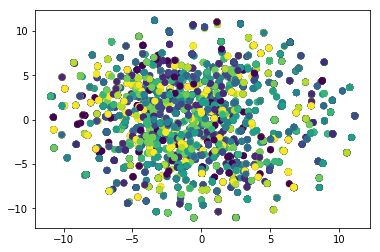

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.389962
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.966032
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.797560
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.807958
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.845970
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.175131
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.584748
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.675569

Test set: Average loss: 1.7199, Accuracy: 3931/10000 (39%)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional proba

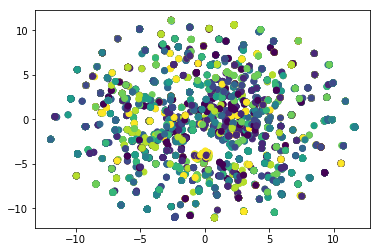

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.653458
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.869986
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.761245
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.475262
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.712079
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.523849
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.932246
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.344144

Test set: Average loss: 1.6810, Accuracy: 4044/10000 (40%)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional proba

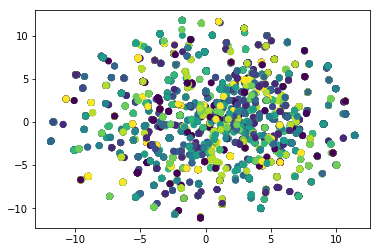

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.435735
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.432025
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.427644
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.661627
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.866278
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.620703
Train Epoch: 3 [38400/50000 (77%)]	Loss: 2.120579
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.519375

Test set: Average loss: 1.6678, Accuracy: 4086/10000 (41%)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional proba

In [ ]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()